# Test validity step 1 : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import camb

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
# from get_freq_maps_SO_64 import *
from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (15, 2, 49152)
Shape for input cmb maps : (15, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,40.0,37.42,26.46,70.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
1,50.0,33.46,23.66,58.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
2,60.0,21.31,15.07,51.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
3,68.0,16.87,11.93,47.1,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
4,78.0,12.07,8.53,43.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
5,89.0,11.30,7.99,41.5,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
6,100.0,6.56,4.64,37.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
7,119.0,4.58,3.24,33.6,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
8,140.0,4.79,3.39,30.8,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD
9,166.0,5.57,3.94,28.9,1.0,forecast,"arXiv:2202.02773, Table 13",satellite,Different instruments at the same freq were co...,LiteBIRD


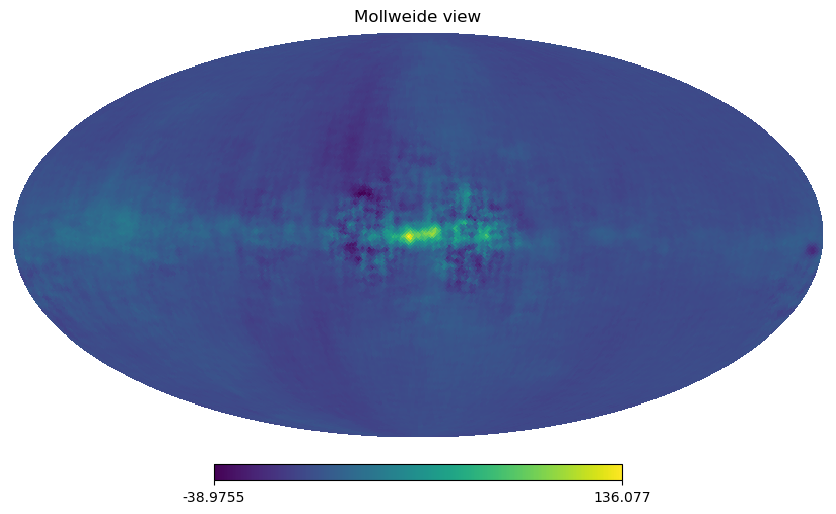

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    # c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

In [8]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]

In [9]:
# mixing_matrix_init = np.array([[1.,         1.,         0.        ],
#                                 [1.,         0.52387813, 0.00182426],
#                                 [1.,         0.3117258,  0.00324908],
#                                 [1.,         0.21971687, 0.00433627],
#                                 [1.,         0.15096497, 0.0057459 ],
#                                 [1.,         0.10631274, 0.0074421 ],
#                                 [1.,         0.07881344, 0.00935487],
#                                 [1.,         0.05159725, 0.0133358 ],
#                                 [1.,         0.03585547, 0.01906532],
#                                 [1.,         0.02552178, 0.02888587],
#                                 [1.,         0.0193825,  0.04508262],
#                                 [1.,         0.01493871, 0.08217483],
#                                 [1.,         0.01211497, 0.16061503],
#                                 [1.,         0.00871575, 0.37616284],
#                                 [1.,         0.,         1.        ]])

In [10]:
# init_mixing_matrix_obj.init_params()

In [12]:
depth_p = instrument['depth_p']

freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)

init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()
# init_params = mixing_matrix_init[1:,1:-1]

mixing_matrix_obj = MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)

In [13]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [14]:

# eta_maps = np.zeros((number_frequencies, nstokes, npix))
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
# eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_maps = micmac.get_sampling_eta_v2(param_dict, red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, lmin=lmin, n_iter=n_iter)



Recalculating x !
Recalculating y !


In [15]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [16]:
covariance_noise = np.zeros_like(c_ell_approx)
# covariance_noise[:nstokes,lmin:] = scipy.linalg.sqrtm(BtinvNB)[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
covariance_noise[:nstokes,lmin:] = BtinvNB[0,0]*np.ones_like(c_ell_approx)[:nstokes,lmin:]
analytical_eta_term = (c_ell_approx + covariance_noise)/np.sqrt(BtinvNB[0,0])

red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.eye(nstokes)/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

In [17]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

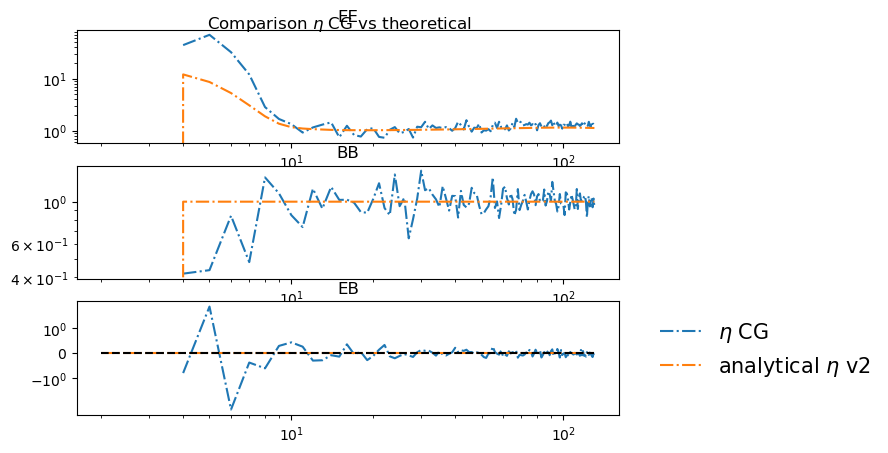

In [18]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']


plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    
    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], '-.', label=r"analytical $\eta$ v2")
    
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()